In [ ]:
"""
Second Random Forest model with more features and balance the classes by oversampling
"""

In [1]:
import pandas as pd
import numpy as np
import datetime
import pickle

In [2]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score 

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter

In [5]:
# the df with features and target

with open('train_val_data.pickle', 'rb') as read_file:
    model_data = pickle.load(read_file)
    
model_data.head()

,company_name,period_end_date,number_of_quarters,submission_number,central_index_key,ein,sic,fiscal_year_end,fiscal_year,form,...,FY_end_day,keep_row,Industry,div_code,Division,FULL_NAME,bankruptcy_date,time_delta,days,target
0,1 800 FLOWERS COM INC,2014-06-30,0,0001437749-17-015969,1084869,113117311,5990,630,2017,10-K,...,30,1,"Retail-Retail Stores, NEC",59,Retail Trade,NaN,NaT,NaT,NaN,0
1,1 800 FLOWERS COM INC,2015-06-30,0,0001437749-18-017027,1084869,113117311,5990,630,2018,10-K,...,30,1,"Retail-Retail Stores, NEC",59,Retail Trade,NaN,NaT,NaT,NaN,0
2,1 800 FLOWERS COM INC,2016-06-30,0,0001437749-19-018360,1084869,113117311,5990,630,2019,10-K,...,30,1,"Retail-Retail Stores, NEC",59,Retail Trade,NaN,NaT,NaT,NaN,0
3,1 800 FLOWERS COM INC,2017-06-30,4,0001437749-19-018360,1084869,113117311,5990,630,2019,10-K,...,30,1,"Retail-Retail Stores, NEC",59,Retail Trade,NaN,NaT,NaT,NaN,0
4,1 800 FLOWERS COM INC,2018-06-30,4,0001437749-19-018360,1084869,113117311,5990,630,2019,10-K,...,30,1,"Retail-Retail Stores, NEC",59,Retail Trade,NaN,NaT,NaT,NaN,0


In [39]:
# account ratios
model_data['debt_ratio'] = model_data['Liabilities'] / model_data['StockholdersEquity']
model_data['debt_equity_ratio'] = model_data['Liabilities'] / model_data['Assets']
#model_data['current_ratio'] = model_data['AssetsCurrent'] / model_data['LiabilitiesCurrent']
model_data['leverage'] = model_data['Assets'] / model_data['StockholdersEquity']
model_data['return_on_equity'] = model_data['NetIncomeLoss'] / model_data['StockholdersEquity']
model_data['return_on_assets'] = model_data['NetIncomeLoss'] / model_data['Assets']

#model_ready['AssetsCurrent_MM'] = model_ready['AssetsCurrent'] / 1e6
#model_ready['Libilities_MM'] = model_ready['Liabilities'] / 1e6
#model_ready['LibilitiesCurrent_MM'] = model_ready['LiabilitiesCurrent'] / 1e6
model_data['NetIncomeLoss_MM'] = model_data['NetIncomeLoss'] / 1e6
#model_ready['StockholdersEquity_MM'] = model_ready['StockholdersEquity'] / 1e6
model_data['OperatingIncomeLoss_MM'] = model_data['OperatingIncomeLoss'] / 1e6

In [40]:
model_data.head()

,company_name,period_end_date,number_of_quarters,submission_number,central_index_key,ein,sic,fiscal_year_end,fiscal_year,form,...,time_delta,days,target,debt_ratio,debt_equity_ratio,leverage,return_on_equity,return_on_assets,NetIncomeLoss_MM,OperatingIncomeLoss_MM
0,1 800 FLOWERS COM INC,2014-06-30,0,0001437749-17-015969,1084869,113117311,5990,630,2017,10-K,...,NaT,NaN,0,0.444534,0.304411,1.460306,NaN,NaN,NaN,23.706
1,1 800 FLOWERS COM INC,2015-06-30,0,0001437749-18-017027,1084869,113117311,5990,630,2018,10-K,...,NaT,NaN,0,1.375958,0.577012,2.384626,NaN,NaN,NaN,37.617
2,1 800 FLOWERS COM INC,2016-06-30,0,0001437749-19-018360,1084869,113117311,5990,630,2019,10-K,...,NaT,NaN,0,1.073248,0.517665,2.073248,NaN,NaN,NaN,43.282
3,1 800 FLOWERS COM INC,2017-06-30,4,0001437749-19-018360,1084869,113117311,5990,630,2019,10-K,...,NaT,NaN,0,0.957454,0.489132,1.957454,0.156042,0.079717,44.041,46.359
4,1 800 FLOWERS COM INC,2018-06-30,4,0001437749-19-018360,1084869,113117311,5990,630,2019,10-K,...,NaT,NaN,0,0.812899,0.448397,1.812899,0.129535,0.071452,40.791,41.048


In [41]:
model_data.columns

Index(['company_name', 'period_end_date', 'number_of_quarters',
       'submission_number', 'central_index_key', 'ein', 'sic',
       'fiscal_year_end', 'fiscal_year', 'form', 'date_filed', 'Assets',
       'AssetsCurrent', 'CashAndCashEquivalentsAtCarryingValue',
       'CashAndCashEquivalentsPeriodIncreaseDecrease', 'CommonStockValue',
       'CostsAndExpenses', 'DeferredIncomeTaxExpenseBenefit',
       'DeferredIncomeTaxLiabilities', 'DeferredIncomeTaxLiabilitiesNet',
       'DeferredIncomeTaxesAndTaxCredits', 'Depreciation',
       'EarningsPerShareBasic', 'EarningsPerShareDiluted', 'GrossProfit',
       'Liabilities', 'LiabilitiesAndStockholdersEquity', 'LiabilitiesCurrent',
       'LongTermDebt', 'LongTermDebtCurrent',
       'LongTermDebtMaturitiesRepaymentsOfPrincipalInNextTwelveMonths',
       'LongTermDebtNoncurrent', 'NetCashProvidedByUsedInFinancingActivities',
       'NetCashProvidedByUsedInInvestingActivities',
       'NetCashProvidedByUsedInOperatingActivities', 'NetInco

In [42]:
model_data2 = model_data[['company_name', 'period_end_date','Division',
         'target', 'debt_ratio', 'EarningsPerShareDiluted',
       'debt_equity_ratio', 'leverage', 'return_on_equity', 'return_on_assets',
                          'NetIncomeLoss_MM', 'OperatingIncomeLoss_MM']]

In [43]:
## RF will not accept NaNs

## change all NaN to zero- as no hard-entered zeros in data, 0 will mean missing
## already done with data clean and prep

model_ready = model_data2.fillna(0)  

#model_ready = model_data.copy()

# replace infinity values from creating ratios where missing num or denom

model_ready.replace([np.inf, -np.inf], 0, inplace=True)

model_ready.head()

,company_name,period_end_date,Division,target,debt_ratio,EarningsPerShareDiluted,debt_equity_ratio,leverage,return_on_equity,return_on_assets,NetIncomeLoss_MM,OperatingIncomeLoss_MM
0,1 800 FLOWERS COM INC,2014-06-30,Retail Trade,0,0.444534,0.23,0.304411,1.460306,0.000000,0.000000,0.000,23.706
1,1 800 FLOWERS COM INC,2015-06-30,Retail Trade,0,1.375958,0.30,0.577012,2.384626,0.000000,0.000000,0.000,37.617
2,1 800 FLOWERS COM INC,2016-06-30,Retail Trade,0,1.073248,0.55,0.517665,2.073248,0.000000,0.000000,0.000,43.282
3,1 800 FLOWERS COM INC,2017-06-30,Retail Trade,0,0.957454,0.65,0.489132,1.957454,0.156042,0.079717,44.041,46.359
4,1 800 FLOWERS COM INC,2018-06-30,Retail Trade,0,0.812899,0.61,0.448397,1.812899,0.129535,0.071452,40.791,41.048


In [44]:
model_ready.shape

(19897, 12)

In [45]:
model_ready.company_name.nunique()

5373

In [46]:
# one hot encoding for the industry division

div_code = model_ready[['Division']]

one = OneHotEncoder(sparse=False)
one.fit(div_code)
cats = one.transform(div_code)

columns = one.get_feature_names(['Division'])
div_code_df = pd.DataFrame(cats, columns=columns, index=div_code.index)

div_code_df

,"Division_Agriculture, Forestry and Fishing",Division_Construction,"Division_Finance, Insurance and Real Estate",Division_Manufacturing,Division_Mining,Division_Retail Trade,Division_Services,"Division_Transportation, Communications, Electric, Gas and Sanitary service",Division_Wholesale Trade
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
19892,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19893,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19894,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19895,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [47]:
rf_ready = pd.concat([model_ready, div_code_df], axis=1)
rf_ready.head()

,company_name,period_end_date,Division,target,debt_ratio,EarningsPerShareDiluted,debt_equity_ratio,leverage,return_on_equity,return_on_assets,...,OperatingIncomeLoss_MM,"Division_Agriculture, Forestry and Fishing",Division_Construction,"Division_Finance, Insurance and Real Estate",Division_Manufacturing,Division_Mining,Division_Retail Trade,Division_Services,"Division_Transportation, Communications, Electric, Gas and Sanitary service",Division_Wholesale Trade
0,1 800 FLOWERS COM INC,2014-06-30,Retail Trade,0,0.444534,0.23,0.304411,1.460306,0.000000,0.000000,...,23.706,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1 800 FLOWERS COM INC,2015-06-30,Retail Trade,0,1.375958,0.30,0.577012,2.384626,0.000000,0.000000,...,37.617,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1 800 FLOWERS COM INC,2016-06-30,Retail Trade,0,1.073248,0.55,0.517665,2.073248,0.000000,0.000000,...,43.282,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1 800 FLOWERS COM INC,2017-06-30,Retail Trade,0,0.957454,0.65,0.489132,1.957454,0.156042,0.079717,...,46.359,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1 800 FLOWERS COM INC,2018-06-30,Retail Trade,0,0.812899,0.61,0.448397,1.812899,0.129535,0.071452,...,41.048,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [48]:
rf_ready.columns

Index(['company_name', 'period_end_date', 'Division', 'target', 'debt_ratio',
       'EarningsPerShareDiluted', 'debt_equity_ratio', 'leverage',
       'return_on_equity', 'return_on_assets', 'NetIncomeLoss_MM',
       'OperatingIncomeLoss_MM', 'Division_Agriculture, Forestry and Fishing',
       'Division_Construction', 'Division_Finance, Insurance and Real Estate',
       'Division_Manufacturing', 'Division_Mining', 'Division_Retail Trade',
       'Division_Services',
       'Division_Transportation, Communications, Electric, Gas and Sanitary service',
       'Division_Wholesale Trade'],
      dtype='object')

In [49]:
rf_ready[['debt_ratio', 'debt_equity_ratio', 'leverage', 'return_on_equity', 
          'return_on_assets', 'EarningsPerShareDiluted', 'NetIncomeLoss_MM',
       'OperatingIncomeLoss_MM']].describe()

,debt_ratio,debt_equity_ratio,leverage,return_on_equity,return_on_assets,EarningsPerShareDiluted,NetIncomeLoss_MM,OperatingIncomeLoss_MM
count,19897.000000,19897.000000,19897.000000,19897.000000,19897.000000,1.989700e+04,19897.000000,19897.000000
mean,2.933923,0.606173,19.396535,0.157092,-0.005257,8.250437e+02,279.814294,321.458763
std,113.114446,0.330674,2134.139095,17.779165,0.163713,1.194998e+05,1727.445249,1815.467360
min,-6570.794872,-1.316642,-6569.794872,-526.555556,-3.840960,-4.580000e+05,-22355.000000,-20727.000000
25%,0.524242,0.399874,1.536884,0.000000,-0.001212,0.000000e+00,-0.918000,0.000000
50%,1.410051,0.616505,2.458952,0.057741,0.010902,4.900000e-01,16.471000,8.027728
75%,3.809700,0.841481,5.043148,0.129523,0.050343,1.910000e+00,128.111000,155.016000
max,11468.592593,4.350200,300505.000000,2396.000000,4.023217,1.685000e+07,59531.000000,71230.000000


In [52]:
# try run without industies and look at feature importance

X = rf_ready[['debt_ratio', 'debt_equity_ratio', 'leverage', 'return_on_equity',  
            'return_on_assets', 'EarningsPerShareDiluted', 'NetIncomeLoss_MM',
       'OperatingIncomeLoss_MM',
              'Division_Mining', 'Division_Agriculture, Forestry and Fishing', 
                 'Division_Construction', 'Division_Finance, Insurance and Real Estate', 
                 'Division_Manufacturing', 'Division_Mining', 'Division_Retail Trade', 
                 'Division_Services', 'Division_Wholesale Trade',
                 'Division_Transportation, Communications, Electric, Gas and Sanitary service']]

#'NetIncomeLoss_MM', 'OperatingIncomeLoss_MM',

y = rf_ready['target']   

# model recal went up a few percent points without the industries  ~0.27

# model recall went up to aoub 0.42 with out the big Loss numbers, but more false positives

## putting in division_mining helped decrease false posivities,  recall to 0.38

# the extra ratios for 

In [53]:
# arrays for KFold
X, y = np.array(X), np.array(y)

kf = KFold(n_splits=5, shuffle=True, random_state = 47)
cv_rfm_recall = [] #collect the recall scores
#cv_rfm_matrix = []

for train_ind, val_ind in kf.split(X, y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #balance the training set classes
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

    
    #Random Forest
    randomforest = RandomForestClassifier(n_estimators=100)

    randomforest.fit(X_resampled, y_resampled)
      
    y_pred = randomforest.predict(X_val)
    
    cv_rfm_recall.append(round(recall_score(y_val, y_pred), 4))
      
    rf_confusion = confusion_matrix(y_val, y_pred)
    
    print('Matrix:' , rf_confusion)

print('RFM recall scores: ', cv_rfm_recall, '\n')

print(f'Mean CV recall: {np.mean(cv_rfm_recall):.3f} +- {np.std(cv_rfm_recall):.3f}', '\n')



Matrix: [[3956    6]
 [  15    3]]
Matrix: [[3952    4]
 [  22    2]]
Matrix: [[3953    6]
 [  19    1]]
Matrix: [[3962    4]
 [  13    0]]
Matrix: [[3950    4]
 [  23    2]]
RFM recall scores:  [0.1667, 0.0833, 0.05, 0.0, 0.08] 

Mean CV recall: 0.076 +- 0.054 



In [ ]:
## adding whole values of the 2 "Loss" didn't help regular oversampling
## nor did it help the SMOTE oversampling

In [ ]:
## try SMOTE oversampling


In [54]:
# arrays for KFold
X, y = np.array(X), np.array(y)

kf = KFold(n_splits=5, shuffle=True, random_state = 47)
cv_rfm_recall = [] #collect the recall scores
#cv_rfm_matrix = []

for train_ind, val_ind in kf.split(X, y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #balance the training set classes
    X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train, y_train)

    #Random Forest
    randomforest = RandomForestClassifier(n_estimators=100)

    randomforest.fit(X_smoted, y_smoted)
      
    y_pred = randomforest.predict(X_val)
    
    cv_rfm_recall.append(round(recall_score(y_val, y_pred), 4))
      
    rf_confusion = confusion_matrix(y_val, y_pred)
    
    print('Matrix:' , rf_confusion)

print('RFM recall scores: ', cv_rfm_recall, '\n')

print(f'Mean CV recall: {np.mean(cv_rfm_recall):.3f} +- {np.std(cv_rfm_recall):.3f}', '\n')


Matrix: [[3942   20]
 [  14    4]]
Matrix: [[3942   14]
 [  20    4]]
Matrix: [[3941   18]
 [  17    3]]
Matrix: [[3948   18]
 [  11    2]]
Matrix: [[3936   18]
 [  20    5]]
RFM recall scores:  [0.2222, 0.1667, 0.15, 0.1538, 0.2] 

Mean CV recall: 0.179 +- 0.028 



In [ ]:
# just the whole numbers rather than the ratios are about 10% better in capture TP, and better in
# capturing less false positives

In [18]:
feature_names =  ['debt_ratio', 'debt_equity_ratio', 'leverage', 'return_on_equity',  
            'return_on_assets', 'EarningsPerShareDiluted', 'Division_Mining', 
                  'Division_Agriculture, Forestry and Fishing', 
                 'Division_Construction', 'Division_Finance, Insurance and Real Estate', 
                 'Division_Manufacturing', 'Division_Mining', 'Division_Retail Trade', 
                 'Division_Services', 'Division_Wholesale Trade',
                 'Division_Transportation, Communications, Electric, Gas and Sanitary service']


<BarContainer object of 16 artists>

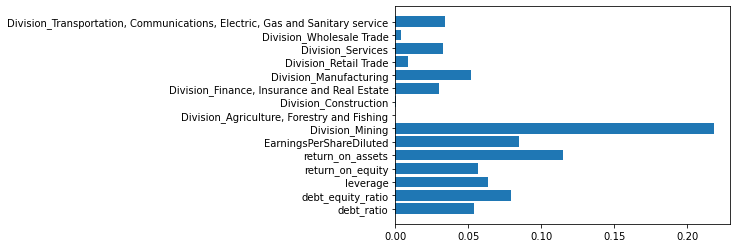

In [19]:
## look at feature importance
## last k-fold
plt.barh(feature_names, randomforest.feature_importances_)